In [2]:
import rebound
%matplotlib inline
import matplotlib.pyplot as plt
import observations
import state
import mcmc
import numpy as np

/Users/rein/git/rebound/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [10]:
true_state = state.State(planets=[{"m":1e-3, "a":1., "h":0.2}])
obs = observations.FakeObservation(true_state, Npoints=100, error=1e-4, tmax=10.)
var_state = state.StateVar(planets=[{"m":1e-3, "a":1., "h":-0.3, "k":0.1, "l":1.4}], ignore_vars=["a","m"])

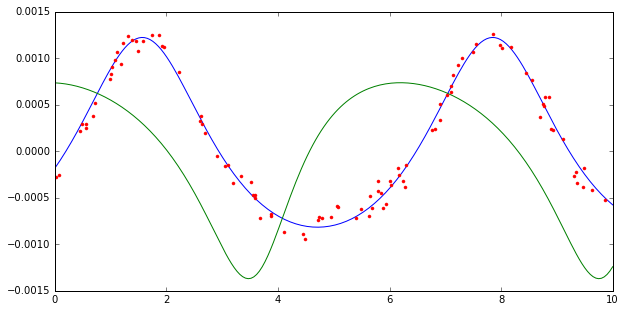

In [11]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.plot(*true_state.get_rv_plotting(tmax=10.))
ax.plot(*var_state.get_rv_plotting(tmax=10.))
ax.plot(obs.t, obs.rv, ".")

In [12]:
Delta = 1e-4
s = state.StateVar(planets=[{"m":1e-3, "a":1., "h":0.2, "k":0., "l":1.4}], ignore_vars=["a","m"])
chi2 = s.get_chi2(obs)
fd_d = np.zeros(s.Nvars)
fd_dd = np.zeros((s.Nvars,s.Nvars))
for i in range(s.Nvars):
    shift = np.zeros(s.Nvars)
    shift[i] = Delta
    s.shift_params(shift);
    chi2p = s.get_chi2(obs)
    s.shift_params(-shift);
    fd_d[i] = (chi2p-chi2)/Delta
    for j in range(s.Nvars):
        shift = np.zeros(s.Nvars)
        shift[i] += Delta
        shift[j] += Delta
        s.shift_params(shift);
        chi2pp = s.get_chi2(obs)
        s.shift_params(-shift);
        
        shift = np.zeros(s.Nvars)
        shift[i] -= Delta
        shift[j] += Delta
        s.shift_params(shift);
        chi2mp = s.get_chi2(obs)
        s.shift_params(-shift);
        
        shift = np.zeros(s.Nvars)
        shift[i] += Delta
        shift[j] -= Delta
        s.shift_params(shift);
        chi2pm = s.get_chi2(obs)
        s.shift_params(-shift);
        
        shift = np.zeros(s.Nvars)
        shift[i] -= Delta
        shift[j] -= Delta
        s.shift_params(shift);
        chi2mm = s.get_chi2(obs)
        s.shift_params(-shift);
        
        fd_dd[i][j] = (chi2pp-chi2mp-chi2pm+chi2mm)/(4.*Delta**2)

chi2, v_d, v_dd = s.get_chi2_d_dd(obs)

print("First order:")
print(fd_d)
print(v_d)
print("\nSecond order:")
print(fd_dd)
print(v_dd)

First order:
[ 28.84375341   2.86152263  91.13158082]
[ 28.84659581   2.85883155  91.13190139]

Second order:
[[-56.83193258  15.13644285  19.05153191]
 [ 15.13644285  53.82944721 -35.79304462]
 [ 19.05153191 -35.79304462  -6.40666258]]
[[-56.83190721  15.1364479   19.05151826]
 [ 15.1364479   53.82947283 -35.79303838]
 [ 19.05151826 -35.79303838  -6.40665029]]


In [ ]:
s = var_state.deepcopy()
mh = mcmc.Mh(s,obs)
mh.scales = 5e-2*np.ones(s.Nvars)
Niter = 1000
chain = np.zeros((Niter,s.Nvars))
chainlogp = np.zeros(Niter)
tries = 0
for i in range(Niter):
    tries += mh.step_force()
    chain[i] = mh.state.get_params()
    chainlogp[i] = mh.state.logp
print("Acceptance rate: %.2f%%"%(float(Niter)/tries*100))

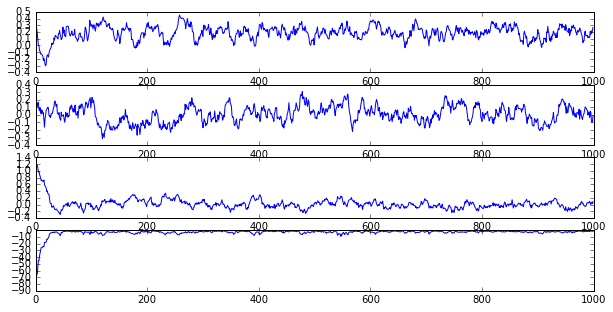

In [44]:
fig = plt.figure(figsize=(10,5))
for i in range(s.Nvars):
    ax = plt.subplot(s.Nvars+1,1,1+i)
    ax.plot(chain[:,i])
ax = plt.subplot(s.Nvars+1,1,s.Nvars+1)
ax.plot(chainlogp)    

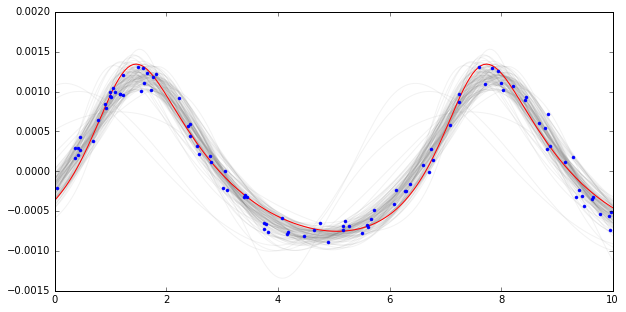

In [45]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
times, rv = true_state.get_rv_plotting(tmax=10.)
for c in np.random.choice(Niter,100):
    s = mh.state.deepcopy()
    s.set_params(chain[c])
    times, rv = s.get_rv_plotting(tmax=10.)
    ax.plot(times, rv, alpha=0.1, color="gray")
ax.plot(times, rv, color="red")
ax.plot(obs.t, obs.rv, ".b")    